In [37]:
import re
import os 
import sys 

import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io

from pathlib import Path
from tqdm.notebook import trange, tqdm
from joblib import Parallel, delayed
from skimage import exposure
import h5py
import pandas as pd
import scanpy as sc
import squidpy as sq
sc.settings.verbosity = 3

from matplotlib.pyplot import rc_context
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from functools import reduce
from matplotlib import cm, colors
import scanorama
import seaborn as sns 
import anndata as ad
from PIL import Image

import dask.dataframe as dd
import dask_ml.cluster 
import scipy
import umap

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)
    

In [6]:
from config import *
import my_io as io

In [7]:
data_ROI = data_dir / 'ROI_new'
dataset = 'ROI002'

# Load data

In [8]:
from sklearn.neighbors import NearestNeighbors

def get_NN(data, n):
    fit = NearestNeighbors(n_neighbors=n).fit(data)
    distances, indices = fit.kneighbors(data)

    return distances, indices

def filter_img_knn(img, n=25, th=3.5):
    # Get avg distances per positive expressed pixels
    x, y = np.where(img > 0)
    values = img[x,y]
    
    data = np.column_stack((x,y))
    distances, indices = get_NN(data, n)
    # avg_dist = np.average(distances, axis=1, weights=values[indices])
    avg_dist = np.average(distances, axis=1)
        
    filter_ind = avg_dist > th
    unique, counts = np.unique(filter_ind, return_counts=True)
    print(unique, counts)
    x_fil = x[filter_ind]
    y_fil = y[filter_ind]

    img_fil = img.copy()
    img_fil[x_fil, y_fil] = 0
    
    return img_fil

def read_img(ROI: str, data_ROI):
    """Read all image from one ROI"""
    dir_ = data_ROI / ROI

    # Get images in directory
    dirpath, _, filenames = next(os.walk(dir_))
    img_name = [
        name
        for name in sorted(filenames)
        if "tiff" in name and 'contaminant' not in name
    ]
    markers = [name.split("_")[-1].split(".")[0] for name in img_name]
    imgs = np.stack(
        [skimage.io.imread(os.path.join(dirpath, name), True) for name in img_name], axis=0
    )
    return imgs, markers

def contrast_streching(img):
    p2, p98 = np.percentile(img, (1,99))
    return exposure.rescale_intensity(img, in_range=(p2, p98), out_range=(0, 255)).astype(np.uint8)

def joblib_loop(task, pics):
    return Parallel(n_jobs=20)(delayed(task)(i) for i in pics)

def read_cell_mask(ROI: str):
    """Read all image from one ROI"""
    dir_ = data_ROI 

    # Get images in directory
    dirpath, _, filenames = next(os.walk(dir_))
    for name in filenames:
        if 'Cell Mask' in name and ROI in name:
            mask_name = name
    mask = skimage.io.imread(os.path.join(dirpath, mask_name))
    return mask

def read_intensity_per_cell(img, mask):
    props = skimage.measure.regionprops_table(mask, img,
                                             properties = ['label', 'mean_intensity', 'area'] )
    df_prop = pd.DataFrame(props)
    df_prop['mean_intensity'] = df_prop['mean_intensity']
    df_prop.drop('area', axis=1, inplace=True)
        
    x_scaled = MinMaxScaler().fit_transform(df_prop[['mean_intensity']])
    df_prop['mean_intensity'] = x_scaled
    
    return df_prop

In [9]:
imgs, markers = read_img(dataset, data_ROI)
imgs = joblib_loop(contrast_streching, imgs)

In [10]:
imgs_filtered = []

for i, img in enumerate(imgs):
    print(markers[i])
    if markers[i] in ['CD103']:
        img_filtered = filter_img_knn(img, th=5)
    else:
        img_filtered = filter_img_knn(img, th=3.5)
    
    # fig, ax = plt.subplots(1,2,figsize=(20,10))
    # ax[0].imshow(img[700:1300, 700:1300], interpolation=None, cmap='hot')
    # ax[0].axis('off')
    # ax[1].imshow(img_filtered[700:1300, 700:1300], interpolation=None, cmap='hot')
    # ax[1].axis('off')
    # fig.subplots_adjust(wspace=0.01)
    # plt.show()
    
    imgs_filtered.append(img_filtered)
imgs_filtered = np.stack(imgs_filtered, axis=0)

SMA
[False  True] [880669  53609]
Vimentin
[False  True] [878104  60781]
TCF1
[False  True] [131165 222484]
CD163
[False  True] [121094 172535]
Pankeratin
[False  True] [194099 172013]
H3K9me3
[False  True] [386676 142847]
PDL1
[False  True] [365602 147634]
CD103
[False  True] [21938 88502]
CD206
[False  True] [ 93151 151985]
CD11c
[False  True] [678011  43144]
FoxP3
[False  True] [335955 154390]
CD4
[False  True] [159245 162882]
E-cadherin
[False  True] [1281117   12600]
CD68
[False  True] [563554 111628]
CD95
[False  True] [   893 106396]
CD20
[False  True] [ 88846 164452]
CD8
[False  True] [1329852   10901]
PD1
[False  True] [  4589 144430]
GranenzymeB
[False  True] [ 27757 153865]
Ki67
[False  True] [  8191 157063]
COL1
[False  True] [559822 111686]
CD3
[False  True] [286595 163888]
Histone3
[False  True] [1588754    6203]
CD45Ro
[False  True] [1280884   10730]
HLADR
[False  True] [1081371   17542]
MHC-II
[False  True] [1423973    8513]


In [139]:
rows, cols = np.nonzero(np.any(imgs_filtered, axis=0))
values = imgs_filtered[:, rows, cols]
df_pixels = pd.DataFrame(values.T, columns=markers)
df_pixels["X"] = rows
df_pixels["Y"] = cols
df_pixels = df_pixels.loc[~(df_pixels.iloc[:,:-2]<30).all(axis=1)]

In [141]:
df_pixels

,SMA,Vimentin,TCF1,CD163,Pankeratin,H3K9me3,PDL1,CD103,CD206,CD11c,...,GranenzymeB,Ki67,COL1,CD3,Histone3,CD45Ro,HLADR,MHC-II,X,Y
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,51,0,0,117,1046
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,54,76,0,0,117,1048
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,45,12,0,0,117,1049
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,38,0,0,118,1044
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,38,0,0,118,1045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654472,41,0,0,0,0,0,0,0,0,0,...,0,0,119,0,145,25,102,110,1499,1488
1654473,136,28,0,0,0,0,0,0,0,0,...,0,0,119,0,85,0,89,25,1499,1489
1654474,142,28,0,0,0,0,0,0,0,0,...,0,0,34,0,52,25,25,42,1499,1490
1654475,65,56,0,0,0,0,0,0,0,0,...,0,0,51,0,33,0,25,76,1499,1491


# Pixels clustering

In [142]:
# Scale data
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(df_pixels.iloc[:, :-2].values)
pixels_scaled = pd.DataFrame(x_scaled, columns=df_pixels.columns[:-2], index=df_pixels.index)

In [143]:
min_intensity = 0.2
marker_subset = ['SMA', 'CD163', 'Pankeratin', 'CD206', 'E-cadherin', 'CD68', 'CD8', 'GranenzymeB', 'COL1', 'HLADR']

pixels_bright = pixels_scaled[marker_subset]
pixels_bright = pixels_bright[~pixels_bright.le(min_intensity).all(axis=1)]

In [144]:
X = dd.from_pandas(pixels_bright, chunksize=50000)

In [145]:
X = X.persist()
X

,SMA,CD163,Pankeratin,CD206,E-cadherin,CD68,CD8,GranenzymeB,COL1,HLADR
npartitions=23,,,,,,,,,,
30,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
67504,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
1620639,...,...,...,...,...,...,...,...,...,...
1654476,...,...,...,...,...,...,...,...,...,...


In [146]:
km = dask_ml.cluster.KMeans(n_clusters=15, oversampling_factor=10)
km.fit(X)

KMeans(n_clusters=15, oversampling_factor=10)

In [147]:
labels = km.labels_
labels = labels.compute()

# Viz

In [148]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(np.log(pixels_bright+1))
pixels_bright_position = pd.DataFrame(x_scaled, columns=pixels_bright.columns, index=pixels_bright.index)

In [149]:
pixels_bright_position["label"] = labels

# Get dataframe per cluster
df_per_label = pixels_bright_position.groupby("label").mean()
df_per_label.head()

,SMA,CD163,Pankeratin,CD206,E-cadherin,CD68,CD8,GranenzymeB,COL1,HLADR
label,,,,,,,,,,
0,-0.201876,0.031863,-0.338022,0.016210,-0.488706,0.253884,-0.324129,-0.127536,-0.089390,2.481481
1,-0.122796,4.149295,-0.335629,4.531569,-0.491998,2.025502,-0.246989,-0.078841,0.104041,1.701924
2,-0.363533,-0.292524,0.103959,-0.259926,2.090891,-0.303776,0.254237,-0.134085,-0.422073,-0.309463
3,3.494655,-0.226504,-0.339760,-0.220450,-0.609087,-0.282035,-0.566147,-0.154402,0.684301,-0.435567
4,-0.153230,3.618637,-0.367265,0.428050,-0.553136,0.758926,-0.344782,-0.116965,-0.053304,0.703270


In [150]:
my_cmap = "bwr"
scale_name = "Z-score"

In [151]:
import scipy.cluster.hierarchy as sch
import matplotlib 
from collections import defaultdict

def create_HM(
    df_per_label, my_cmap, row_colors, scale_name, cellSizePixels=20, **kwargs
):
    # Calulate the figure size, this gets us close, but not quite to the right place
    dpi = matplotlib.rcParams["figure.dpi"]
    marginWidth = (
        matplotlib.rcParams["figure.subplot.right"]
        - matplotlib.rcParams["figure.subplot.left"]
    )
    marginHeight = (
        matplotlib.rcParams["figure.subplot.top"]
        - matplotlib.rcParams["figure.subplot.bottom"]
    )
    Ny, Nx = df_per_label.shape
    figWidth = (Nx * cellSizePixels / dpi) / marginWidth
    figHeigh = (Ny * cellSizePixels / dpi) / marginHeight

    ax = sns.clustermap(
        df_per_label,
        cbar_kws={"fraction": 0.01},
        cmap=my_cmap,
        linewidth=0.1,
        col_cluster=False,
        row_colors=[row_colors],
        dendrogram_ratio=(0.1, 0.0),
        figsize=(figWidth, figHeigh),
        **kwargs,
    )
    ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), rotation=0)
    ax.ax_heatmap.set_xticklabels(
        ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
    )
    ax.ax_heatmap.set_xlabel("Marker")
    ax.ax_heatmap.set_ylabel("Cluster")

    # calculate the size of the heatmap axes
    axWidth = (Nx * cellSizePixels) / (figWidth * dpi)
    axHeight = (Ny * cellSizePixels) / (figHeigh * dpi)

    # resize heatmap
    ax_heatmap_orig_pos = ax.ax_heatmap.get_position()
    ax.ax_heatmap.set_position(
        [ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0, axWidth, axHeight]
    )

    # resize dendrograms to match
    ax_row_orig_pos = ax.ax_row_dendrogram.get_position()
    ax.ax_row_dendrogram.set_position(
        [ax_row_orig_pos.x0, ax_row_orig_pos.y0, ax_row_orig_pos.width, axHeight]
    )
    ax_row_orig_pos = ax.ax_row_colors.get_position()
    ax.ax_row_colors.set_position(
        [ax_row_orig_pos.x0, ax_row_orig_pos.y0, ax_row_orig_pos.width, axHeight]
    )
    
    pos = ax.ax_heatmap.get_position()
    cbar_size=0.2
    ax.ax_cbar.set_position((1.05, pos.y0, .03, cbar_size))

    # Change colorbar label position
    cbar = ax.ax_heatmap.collections[0].colorbar
    cbar.set_label(scale_name, fontsize=12)

    for _, spine in ax.ax_heatmap.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)


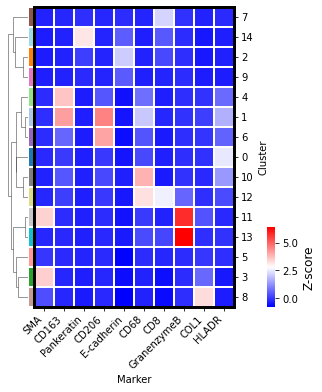

In [152]:
# Get linkage
d = sch.distance.pdist(df_per_label, metric='cosine')
L = sch.linkage(d, method="average")

# Get colormap
vals = np.linspace(0, 1, len(df_per_label))
my_cmap_row = plt.cm.tab20(vals)

# Clustermap and umap
labels = df_per_label.index.to_list()
my_cmap_dict = dict(zip(labels, my_cmap_row))
row_colors = pd.DataFrame(labels)[0].map(my_cmap_dict)
create_HM(df_per_label, my_cmap, row_colors, scale_name, row_linkage=L)
plt.show()

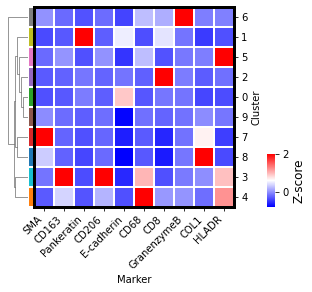

In [153]:
tol = 0.35

# Merge similar cluster
clusters = sch.fcluster(L, tol * d.max(), "distance") - 1
clusters_unique = np.unique(clusters)
n_clusters = len(np.unique(clusters))

# Clustermap and umap
label2cluster = dict(zip(labels, clusters))
result = defaultdict(int)
for k, v in zip(clusters, labels):
    result[k] = max(result[k], v)
row_colors = pd.DataFrame(labels)[0].map(label2cluster).map(result).map(my_cmap_dict)
clusters = np.array(list(map(label2cluster.get, labels)))
new_parc_labels = np.array(list(map(result.get, clusters)))
# create_HM(df_per_label, my_cmap, row_colors, scale_name, row_linkage=L)

# Clustermap and umap with new colormap
vals = np.linspace(0, 1, n_clusters)
np.random.seed(0)
np.random.shuffle(vals)
my_cmap_row = plt.cm.tab10(vals)
my_cmap_dict = dict(zip(clusters_unique, my_cmap_row))
row_colors = pd.DataFrame(labels)[0].map(label2cluster).map(my_cmap_dict)
new_parc_labels = np.array(list(map(label2cluster.get, labels)))
# create_HM(df_per_label, my_cmap, row_colors, scale_name, row_linkage=L)

# Combined 
df_combined = pixels_bright_position.copy()
df_combined.label = df_combined.label.map(label2cluster.get)
df_combined = df_combined.groupby("label").mean()
labels = df_combined.index.to_list()

row_colors = pd.DataFrame(labels)[0].map(my_cmap_dict)

create_HM(df_combined, my_cmap, row_colors, scale_name, vmax=2)
plt.show()

# Pixel location visualization

First we add back the location and condition information in the pixel_bright dataframe

In [154]:
def create_image_cluster(df, mask, label2cluster=None):
    # Create image from pixel location
    x_max, y_max = mask.shape

    x = df.X.tolist()
    y = df.Y.tolist()
    if label2cluster:
        values = df.label.map(label2cluster).tolist()
    else:
        values = np.array(df.label.tolist())
        
    img = np.zeros((x_max, y_max)) * np.nan
    img[x, y] = values
    return img, x, y, values

def fov_cluster(img, my_cmap, savepath=None):
    # Get random colormap
    my_cmap_pixel = plt.cm.colors.ListedColormap(my_cmap)

    # Show contour
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.imshow(img, cmap=my_cmap_pixel, interpolation="none", vmin=0, vmax=len(my_cmap)-1)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(bottom=False, labelbottom=False,
                   left=False, labelleft=False)
    ax.patch.set_facecolor("k")
    if savepath:
        fig.savefig(savepath, bbox_inches="tight")


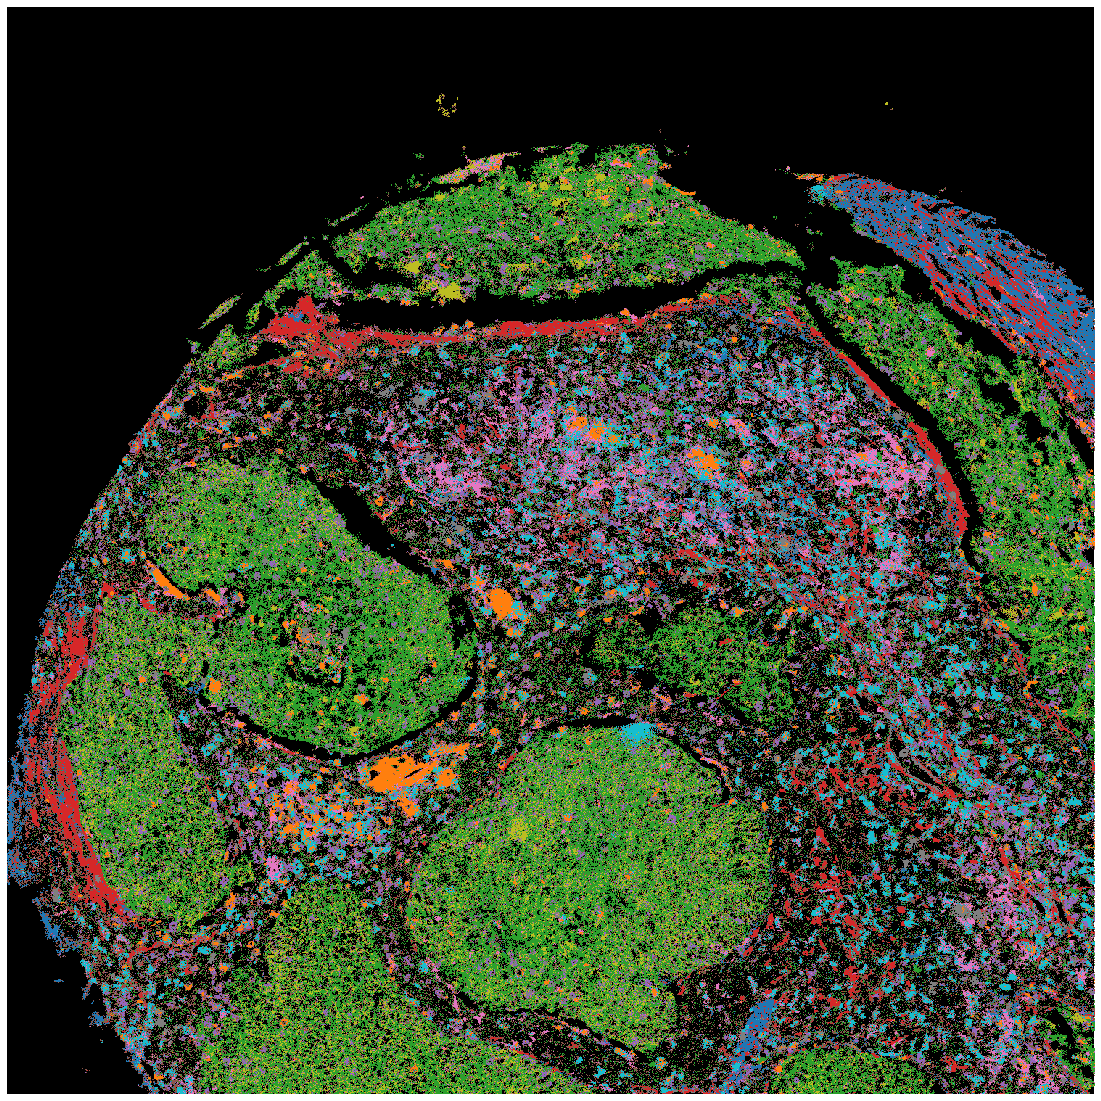

In [155]:
df_subset = pixels_bright_position.join(df_pixels[['X','Y']])

img, _,_,_ = create_image_cluster(df_subset, imgs_filtered[0], label2cluster)
fov_cluster(img, my_cmap_row)


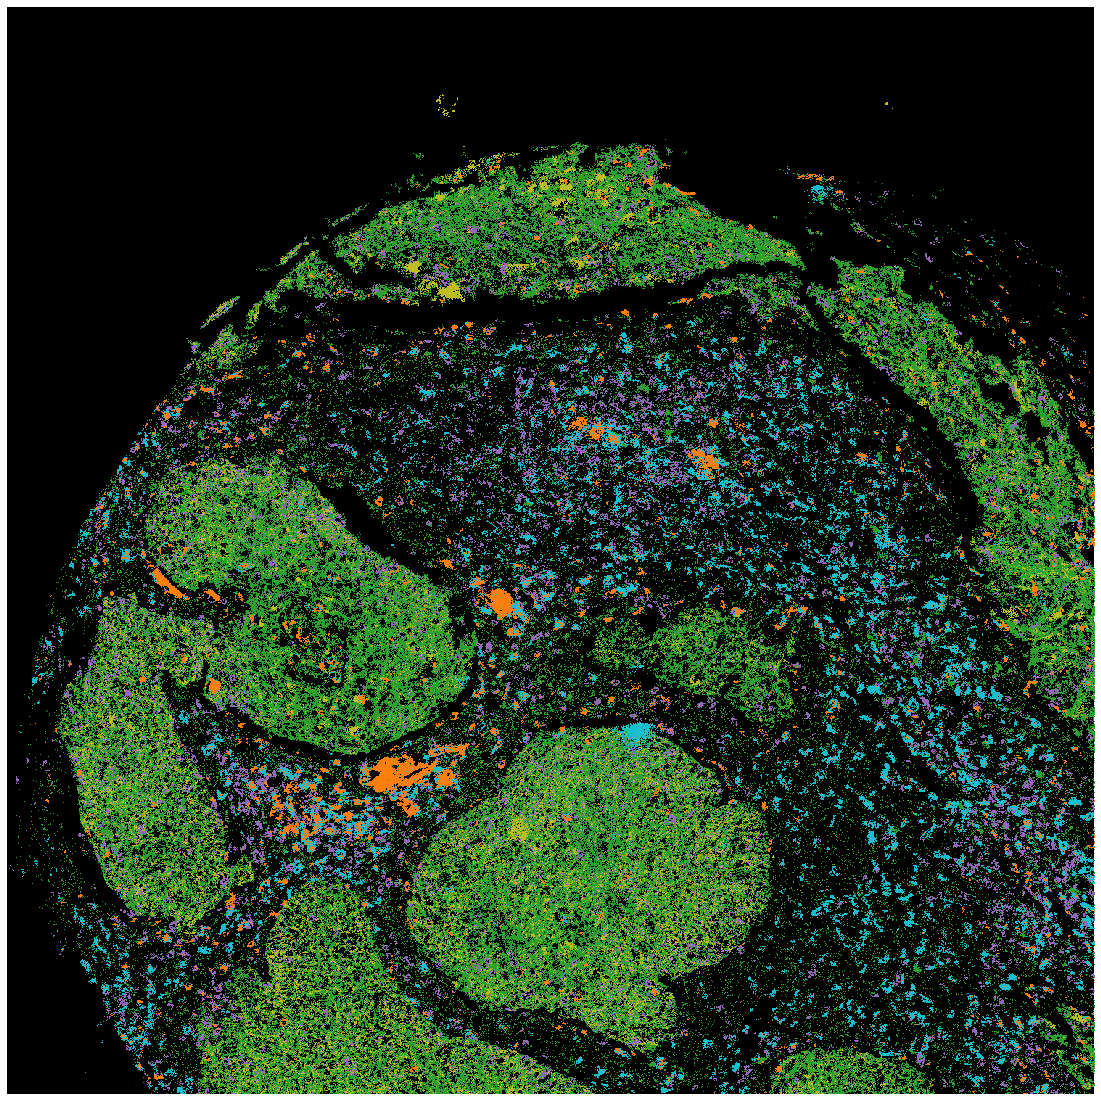

In [158]:
cluster_subset = [0,1,2,3,4]
img_subset = np.where(np.isin(img, cluster_subset), img, np.nan)
fov_cluster(img_subset, my_cmap_row)

# Neighborhood analysis

In [209]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MiniBatchKMeans
from kneed import KneeLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import rc_context

def get_NN(adata, n):
    data = adata.obsm['spatial']
    fit = NearestNeighbors(n_neighbors=n+1).fit(data)
    # fit = NearestNeighbors(n_neighbors=n).fit(data)
    m = fit.kneighbors(data)
    m = m[0][:,1:], m[1][:,1:]
    # m = m[0], m[1] # Distances, Indices

    #sort_neighbors
    args = m[0].argsort(axis = 1)
    add = np.arange(m[1].shape[0])*m[1].shape[1] # arange for number of elements with step of number of neighbors
    sorted_indices = m[1].flatten()[args+add[:,None]] # Extract indices in sorted order 
    return sorted_indices

def neighbor_frequency(adata, n):
    dummies = pd.get_dummies(adata.obs['label']).values
    cols = get_NN(adata,n)
    window = dummies[cols].flatten()
    window = window.reshape(-1, n, dummies.shape[1])
    window = window.sum(axis = 1) / n
    assert len(window) == len(adata.X)

    return window

In [200]:
adata = sc.AnnData(df_subset.iloc[:,:-3].values)
adata.var_names = df_subset.iloc[:,:-3].columns.tolist()
adata.obsm['spatial'] = df_subset[['Y','X']].to_numpy()
adata.obs['label'] = df_subset.label.map(label2cluster).to_numpy().astype('str')
adata.obs['label'] = adata.obs['label'].astype('category')

In [201]:
n_neighbors = 50

windows = neighbor_frequency(adata, n_neighbors)
assert len(windows) == len(adata.X) 

In [202]:
adata_CN = adata[:,:windows.shape[1]]
adata_CN.X = windows
adata_CN.var_names = pd.get_dummies(adata.obs['label']).columns.to_list()

In [203]:
n_neighborhoods = 6

km = MiniBatchKMeans(n_clusters = n_neighborhoods, random_state=0)

labels = km.fit_predict(adata_CN.X)
k_centroids = km.cluster_centers_

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [204]:
adata_CN.obs['CN'] = labels
adata_CN.obs['CN'] = adata_CN.obs['CN'].astype('category')
adata_CN.uns['CN_colors'] = sc.pl.palettes.vega_20_scanpy[:n_neighborhoods]

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_CN']`


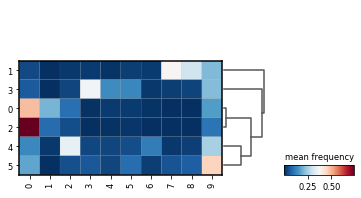

In [205]:
sc.tl.dendrogram(adata_CN, groupby='CN')
sc.pl.matrixplot(adata_CN, adata_CN.var_names.tolist(), 'CN', dendrogram=True,
                 colorbar_title='mean frequency', cmap='RdBu_r')

In [206]:
adata.obs['CN'] = labels
adata.obs['CN'] = adata.obs['CN'].astype('category')
adata.uns['CN_colors'] = sc.pl.palettes.vega_20_scanpy[:n_neighborhoods]
sc.tl.dendrogram(adata, groupby='CN')


    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_CN']`


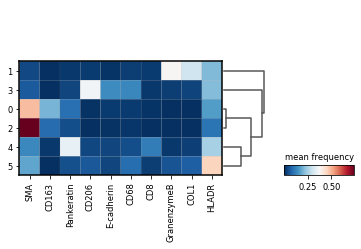

In [208]:
sc.pl.matrixplot(adata, adata.var_names.tolist(), 'CN', dendrogram=True,
                 colorbar_title='mean frequency', cmap='RdBu_r')

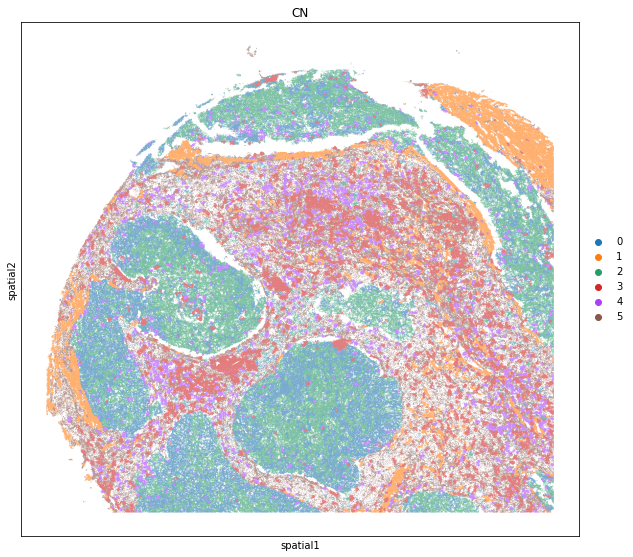

In [211]:
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.spatial(
        adata_CN,
        color='CN',
        spot_size=1,
            )   

In [212]:
colors = adata_CN.uns['CN_colors']
labels = np.unique(adata_CN.obs.CN.tolist())

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb)*255
colors_rgb = colors_rgb.astype(np.uint8)

In [217]:
spatial = adata_CN.obsm['spatial']
    
x = np.asarray(spatial[:,0])
y = np.asarray(spatial[:,1])
values = adata_CN.obs['CN'].to_numpy().astype(np.uint8)

x_max = np.max(x)+1
y_max = np.max(y)+1
img = np.zeros((x_max, y_max, 3), dtype=np.uint8)
img[y, x, :] = colors_rgb[values]

img = Image.fromarray(img)

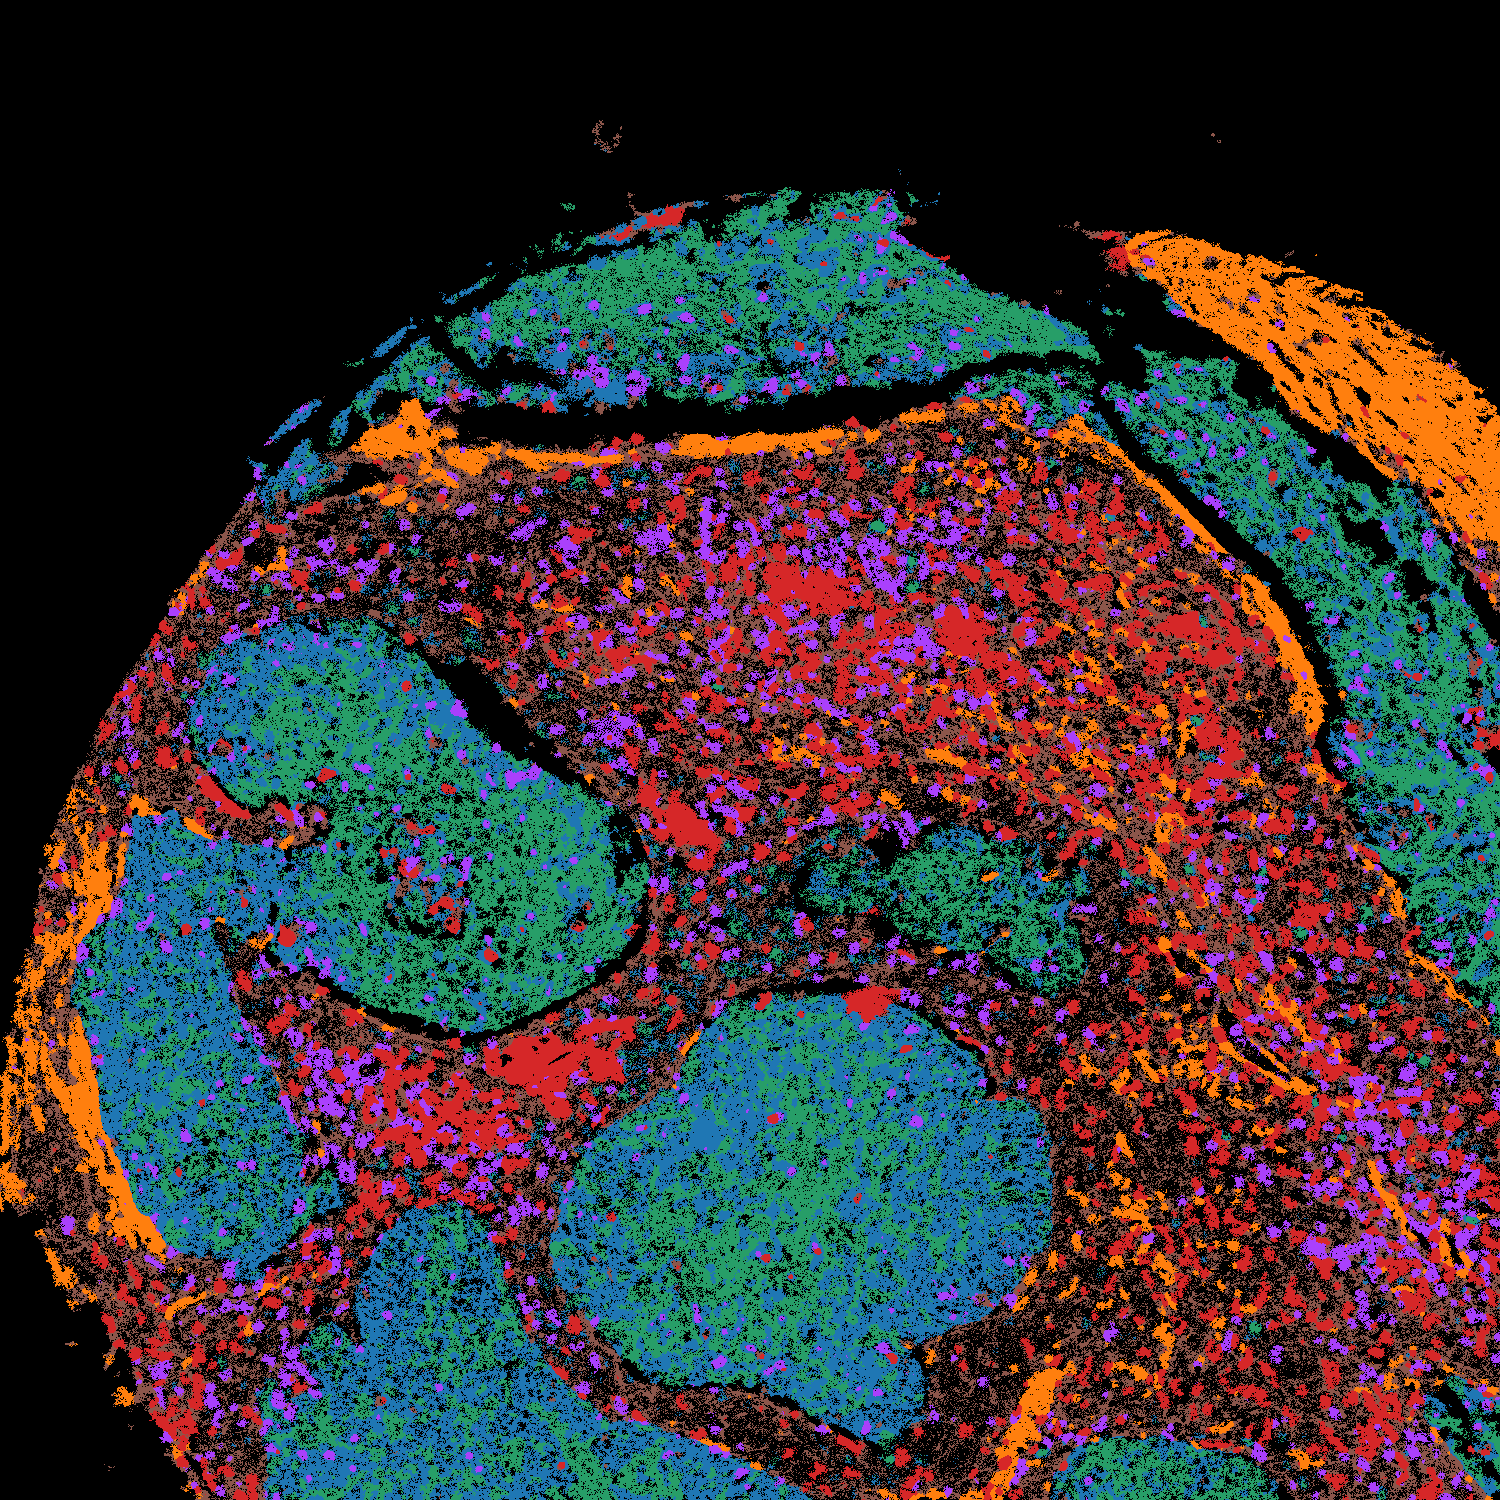

In [218]:
img